In [41]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import seaborn as sns
import random
import IPython.display
import librosa
from sklearn.model_selection import train_test_split
import torchaudio.transforms as transforms

In [3]:
audios = []
labels = []
audio_files = os.listdir('Crema')
for file in audio_files:
    labels.append(file.split('_')[2])
    fs,data = wavfile.read(os.path.join('Crema',file))
    audios.append([data,fs])
    

In [4]:
print(len(labels))
print(len(audios))

7442
7442


In [5]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [6]:
fs_list = [x for _,x in audios]
set(fs_list) # all files have a sample rate of 16kHz

{16000}

,data,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ANG
1,"[[30, 43, 52, 59, 77, 87, 108, 115, 152, 149, ...",DIS
2,"[[263, 277, 274, 244, 240, 220, 195, 191, 161,...",FEA
3,"[[-142, -107, -99, -88, -94, -53, -63, -40, -2...",HAP
4,"[[79, 45, 43, 19, -22, -65, -92, -101, -144, -...",NEU
...,...,...
7437,"[[30, 46, 45, 48, 34, 38, 34, 32, 9, 26, 27, 2...",DIS
7438,"[[-228, -222, -236, -251, -236, -249, -254, -2...",FEA
7439,"[[-74, -61, -76, -71, -67, -56, -74, -66, -73,...",HAP
7440,"[[-53, -35, -25, -19, -3, 8, 19, 20, 24, 61, 6...",NEU


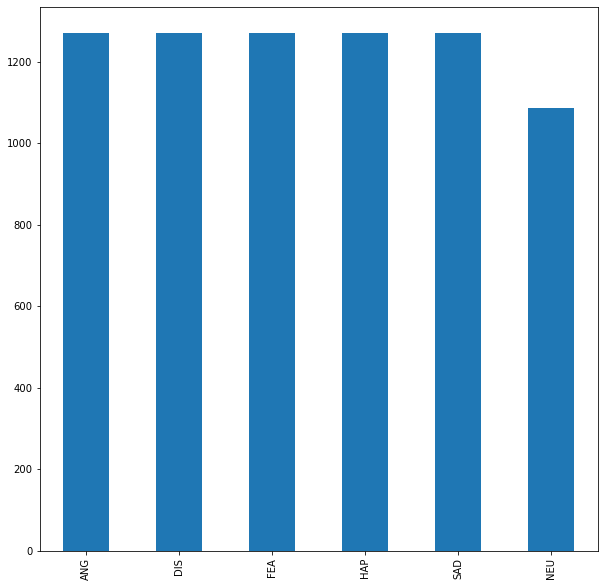

In [7]:
df = pd.concat([pd.Series(audios,name='data'),pd.Series(labels,name='label')],axis=1)
df['label'].value_counts().plot(kind='bar',figsize=(10,10))
df

In [8]:
audio = df['data'][0][0]
a = np.array(audio,dtype='float')
a.size

# zcr = np.nonzero(np.diff(audio > 0))[0]
# zero_crosses.size/audio.size
zcr=librosa.feature.zero_crossing_rate(a,frame_length=2048,hop_length=128)
# for i in np.squeeze(zcr):
#     print(i)
np.squeeze(zcr).size


285

In [9]:
emotions = {'ANG':'Angry','SAD':'Sad','NEU':'Neutral','HAP':'Happy','FEA':'Fear','DIS':'Disgust'}
colors = {'ANG':'red','SAD':'navy','NEU':'black','HAP':'yellow','FEA':'purple','DIS':'green'}

def load_audio(df,emotion):

    audios = list(df[df['label'] == emotion]['data'])
    idx = random.randint(0,len(audios)-1) # choosing a random file of that emotion
    audio = audios[idx][0]
    fs = audios[idx][1]
    duration = len(audio)/fs

    time = np.arange(0,duration,1/fs) # time vector

    plt.figure(figsize=(16,8))
    plt.plot(time,audio,color=colors[emotion])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(emotions[emotion] + ' Waveform')
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.show()
    return audio, fs

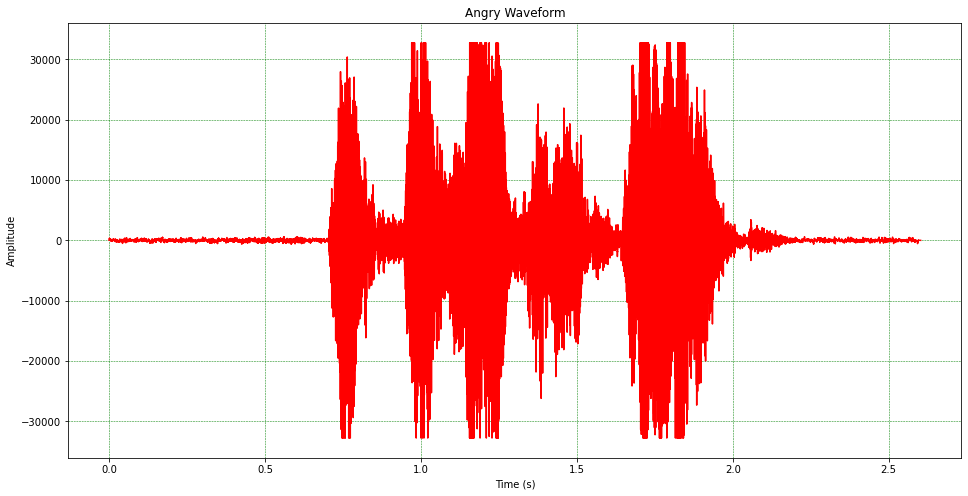

In [13]:
# ANGRY
audio,fs = load_audio(df,'ANG')
IPython.display.Audio(audio,rate=fs)


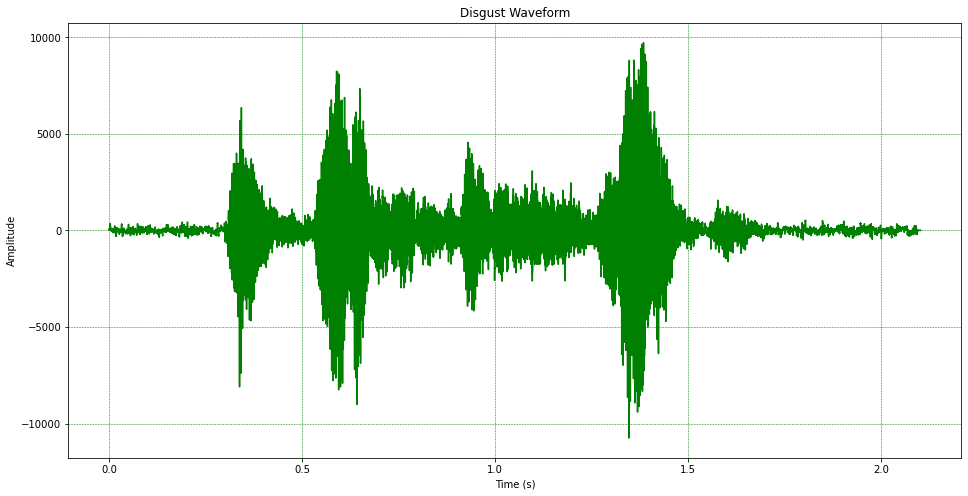

In [18]:
# DISGUSTED 
audio,fs = load_audio(df,'DIS')
IPython.display.Audio(audio,rate=fs)

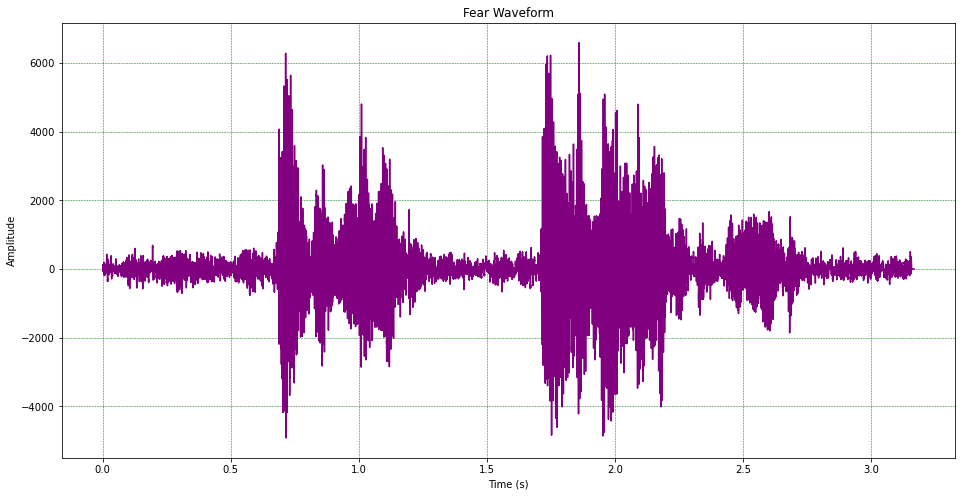

In [22]:
# FEAR
audio,fs = load_audio(df,'FEA')
IPython.display.Audio(audio,rate=fs)

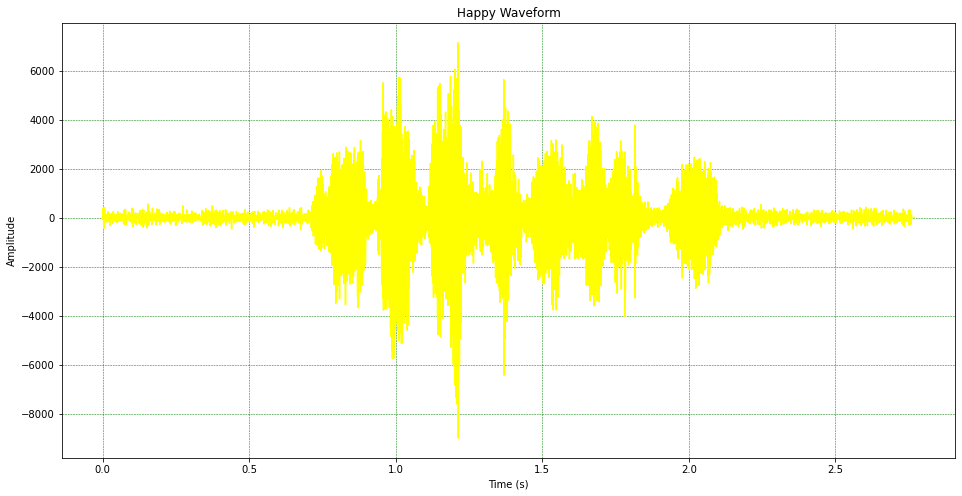

In [23]:
# HAPPY
audio,fs = load_audio(df,'HAP')
IPython.display.Audio(audio,rate=fs)

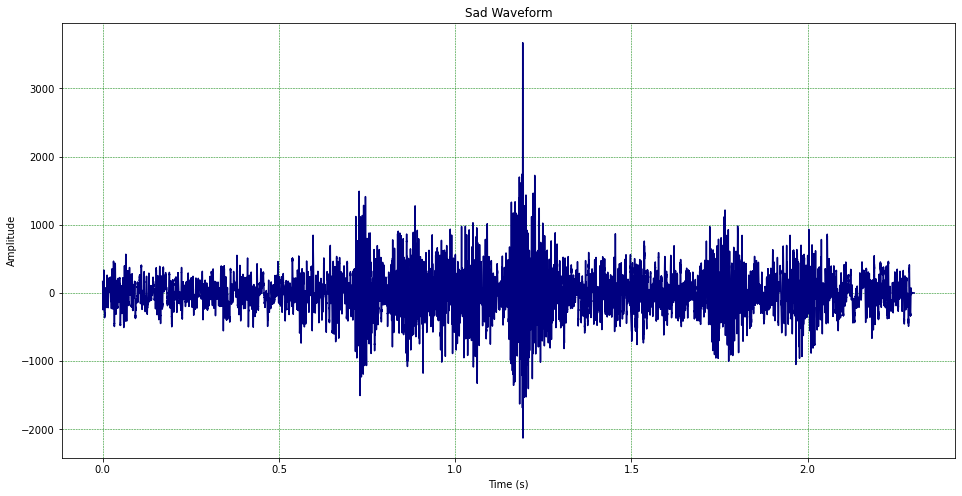

In [27]:
# SAD
audio,fs = load_audio(df,'SAD')
IPython.display.Audio(audio,rate=fs)

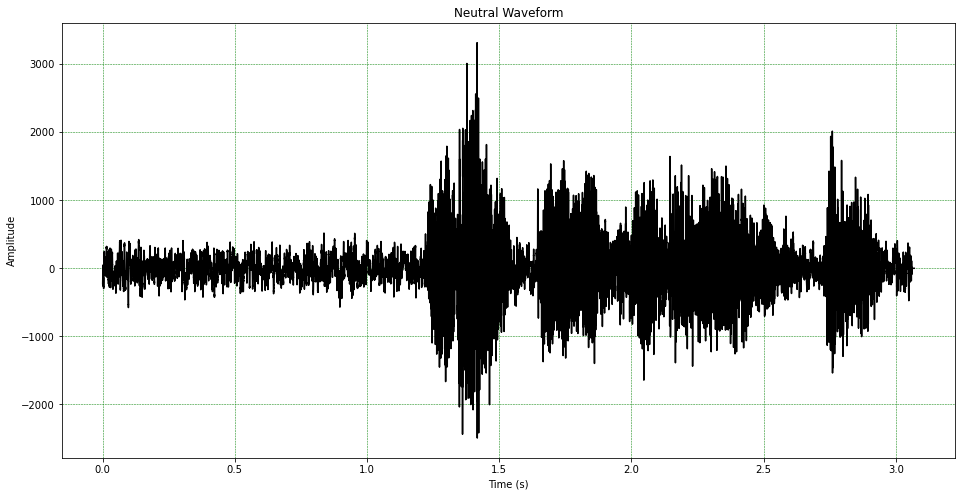

In [28]:
# NEUTRAL
audio,fs = load_audio(df,'NEU')
IPython.display.Audio(audio,rate=fs)

In [94]:
def pad(list,mel_spectrogram=False):
    padded_list = []
    if not mel_spectrogram:
        max_len =  max([i.size for i in list])
        for l in list:
            if not l.size == max_len:
                padded_list.append(np.pad(l, (0, max_len-l.size), 'constant'))
            else:
                padded_list.append(l)
    else:
        max_len =  max([i.shape[0] for i in list])
        for l in list:
            if not l.shape[0] == max_len:
                padded_list.append(np.pad(l, [(0, max_len-l.shape[0]), (0, 0)], mode='constant'))
            else:
                padded_list.append(l)
    return padded_list


In [30]:
df.to_numpy().shape

(7442, 2)

In [44]:
df['data'][0][0]

array([0, 0, 0, ..., 2, 0, 0], dtype=int16)

In [103]:
mels = []
for i in range(df.to_numpy().shape[0]):
    mel = librosa.feature.melspectrogram(y=np.array(df['data'][i][0],dtype='float'), sr=df['data'][i][1],n_fft=1024,n_mels=157).T
    mels.append(mel)




In [104]:
padded_mels=pad(mels,mel_spectrogram=True)

In [105]:
padded_mels[4].shape

(157, 157)

In [106]:
def create_feature_space(df,mel_spectrogram=False):
    labels = []
    if not mel_spectrogram: # time/freq domain feature space
        feature_space = []
        zcrs=[]
        energies=[]
        mfccs=[]
        lfccs = []
        transform = transforms.LFCC(
        speckwargs={"n_fft": 400, "hop_length": 512, "center": False})
        for i,data in enumerate(df.to_numpy()):
            audio = np.array(data[0][0],dtype='float')
            fs = data[0][1]
            # zero_crosses = np.nonzero(np.diff(audio > 0))[0]
            # zcr = zero_crosses.size/len(audio) # zero crossing rate

            # zero crossing rate
            zcr=np.squeeze(librosa.feature.zero_crossing_rate(audio,frame_length=2048,hop_length=128))
            # print(zcr.shape)
            zcrs.append(zcr)

            # normalized energy
            # energy=np.squeeze(librosa.feature.rms(audio,frame_length=2048,hop_length=128))
            energy = np.array([sum(abs(audio[i:i+2048]**2))/2048 for i in range(0, len(audio), 128)])
            # print(energy.shape)
            energies.append(energy)

            # mel frequency cepstral coefficient (MFCC)
            mfcc=np.ravel(librosa.feature.mfcc(y=audio,sr=fs).T)
            # print(mfcc.shape)
            mfccs.append(mfcc)
            
            lfcc = transform(audio)
            lfccs.append(lfcc)
            
            # feature_space.append(np.concatenate((zcr,energy,mfcc), axis=None))
            labels.append(data[1])

            if i%1000==0:
                print(f'audio #{i} checkpoint')

        # max_len = max([len(i) for i in zcrs]) # find the longest list of scr to pad the others until they have equal length
        zcrs = pad(zcrs)
        energies = pad(energies)
        mfccs = pad(mfccs)
        lfccs = pad(lfccs)

        for i in range(df.to_numpy().shape[0]):
            feature_space.append(np.concatenate((zcrs[i],energies[i],mfccs[i],lfccs[i]), axis=None))
        
        return feature_space,labels
    else:
        mels=[]
        for i,data in enumerate(df.to_numpy()):
            audio = np.array(data[0][0],dtype='float')
            fs = data[0][1]
            mel = librosa.feature.melspectrogram(y=audio, sr=fs, n_fft=1024,n_mels=157).T
            mels.append(mel)
            labels.append(data[1])
            if i%1000==0:
                print(f'audio #{i} checkpoint')
        mels = pad(mels,mel_spectrogram=True)
        return mels,labels



In [107]:
mels,labels =create_feature_space(df,mel_spectrogram=True)

audio #0 checkpoint
audio #1000 checkpoint
audio #2000 checkpoint
audio #3000 checkpoint
audio #4000 checkpoint
audio #5000 checkpoint
audio #6000 checkpoint
audio #7000 checkpoint


In [108]:
len(labels)

7442

In [109]:
# len(space)
mels[0].shape

(157, 157)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(mels, labels, test_size=0.3, random_state=42,stratify=labels)
